In [2]:
import pandas as pd
from datasets import Dataset, Audio
from sklearn.model_selection import train_test_split
import torch
import numpy as np
import librosa

In [3]:
def group_accent(accent):
    accent = accent.lower()
    
    if any(x in accent for x in ["united states", "us", "california", "maine", "washington", "midwestern", "ohio", "iowa"]):
        return "American English"
    elif any(x in accent for x in ["england", "british", "yorkshire", "sussex", "welsh", "received pronunciation"]):
        return "British English"
    elif "scottish" in accent:
        return "Scottish English"
    elif "irish" in accent or "northern irish" in accent:
        return "Irish English"
    elif "canadian" in accent or "quebec" in accent:
        return "Canadian English"
    elif "australian" in accent or "new zealand" in accent:
        return "Australian/NZ English"
    elif any(x in accent for x in ["india", "indian", "sri lanka", "pakistan", "bangladeshi", "tamil", "nepali"]):
        return "South Asian English"
    elif any(x in accent for x in ["nigerian", "kenyan", "ugandan", "rwandan", "southern african"]):
        return "African English"
    elif any(x in accent for x in ["german", "dutch", "swedish", "russian", "croatian", "slavic", "balkan", "european", "azerbaijani"]):
        return "European English"
    elif any(x in accent for x in ["arabic", "egyptian"]):
        return "Middle Eastern/Arabic English"
    elif any(x in accent for x in ["filipino", "malaysian", "thai", "bidayuh", "hong kong", "taiwan", "waray"]):
        return "Southeast Asian English"
    elif "brazil" in accent:
        return "Latin American English"
    elif "mid-atlantic" in accent or "awful" in accent or "mixed" in accent:
        return "Other"
    else:
        return "Other"


# Prétraitement

In [4]:
OUTPUT_CSV = "../../data/En/processed/Common Voice.csv" 
df = pd.read_csv(OUTPUT_CSV)
df = df.dropna(subset=['wav_path', 'accents'])

In [5]:
df["accent_group"] = df["accents"].apply(group_accent)
df = df[df["accent_group"] != "Other"]
df.reset_index(drop=True, inplace=True)

In [6]:
print(df["accent_group"].value_counts())


accent_group
Scottish English                 4356
American English                 3718
Southeast Asian English          2203
Irish English                    2162
Canadian English                  648
British English                   406
European English                  338
South Asian English               242
African English                    45
Latin American English             23
Middle Eastern/Arabic English      10
Australian/NZ English               5
Name: count, dtype: int64


In [7]:
df = df[df["accent_group"] != "Other"]
df.reset_index(drop=True, inplace=True)

df = Dataset.from_pandas(df)

cols_to_keep = ["wav_path", "accent_group"]
df = df.remove_columns([col for col in df.column_names if col not in cols_to_keep])

df = df.cast_column("wav_path", Audio(decode=False))

In [8]:
accents = sorted(set(df["accent_group"]))
label2id = {label: i for i, label in enumerate(accents)}
id2label = {i: label for label, i in label2id.items()}

# -- Remplacer accents par id --
def encode_labels(example):
    return {"label": label2id[example["accent_group"]]}
df = df.map(encode_labels)

Map: 100%|██████████| 14156/14156 [00:00<00:00, 26767.05 examples/s]


In [9]:
df['accent_group']

Column(['American English', 'American English', 'American English', 'American English', 'American English'])

In [10]:
df = df.train_test_split(test_size=0.2, seed=2)

In [11]:
accents1 = sorted(set(df['test']["accent_group"]))
print(len(accents1))

accents2 = sorted(set(df['train']["accent_group"]))
print(len(accents2))

df

12
12


DatasetDict({
    train: Dataset({
        features: ['wav_path', 'accent_group', 'label'],
        num_rows: 11324
    })
    test: Dataset({
        features: ['wav_path', 'accent_group', 'label'],
        num_rows: 2832
    })
})

In [12]:
from torch.utils.data import Dataset
import soundfile as sf

class AudioDataset(Dataset):
    def __init__(self, hf_dataset, processor, audio_dir):
        self.dataset = hf_dataset
        self.processor = processor
        self.audio_dir = audio_dir

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]
        path = f"{self.audio_dir}/{example['wav_path']['path']}"
        waveform, sr = sf.read(path)
        if waveform.ndim == 2:
            waveform = waveform.mean(axis=1)

        inputs = self.processor(
            waveform,
            sampling_rate=sr,
            return_tensors="pt",
            padding="longest",
            truncation=True,
            max_length=16000
        )
        
        return {
            "input_values": inputs.input_values.squeeze(0),
            "label": example["label"]
        }


In [13]:
from torch.nn.utils.rnn import pad_sequence

def data_collator(batch):
    input_values = [example["input_values"] for example in batch]
    labels = [example["label"] for example in batch]

    input_values_padded = pad_sequence(input_values, batch_first=True, padding_value=0.0)

    return {
        "input_values": input_values_padded,
        "labels": torch.tensor(labels, dtype=torch.long)
    }


In [14]:
from transformers import AutoFeatureExtractor

processor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base")

train_dataset = AudioDataset(df['train'], processor, audio_dir="../../clips_en.wav")
test_dataset = AudioDataset(df['test'], processor, audio_dir="../../clips_en.wav")

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=data_collator)
eval_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=data_collator)


c:\Simoh\Github\Transcription_Accent_Model_Comparer\.venv\Lib\site-packages\transformers\configuration_utils.py:309: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


# Evaluation

In [17]:
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

num_labels = len(id2label)
model = AutoModelForAudioClassification.from_pretrained(
    "facebook/wav2vec2-base", num_labels=num_labels, label2id=label2id, id2label=id2label
)
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1_minority': [],
    "val_f1_macro": [],
    "val_f1_weighted": [],
}

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
EPOCHS = 17

In [19]:
from transformers import get_scheduler
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

num_training_steps = len(train_dataloader) * EPOCHS # 10 epochs
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),
    num_training_steps=num_training_steps,
)


In [20]:
from collections import Counter
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

all_labels = [example["accent_group"] for example in df["train"]]
label_counts = Counter(all_labels)

label2id = {label: i for i, label in enumerate(accents)}
num_classes = len(label2id)


counts = np.array([label_counts[label] for label in accents])
class_weights = 1.0 / counts
class_weights = class_weights / class_weights.sum()  


class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

from torch.nn import CrossEntropyLoss

loss_fn = CrossEntropyLoss(weight=class_weights_tensor)



In [21]:
class_weights_tensor

tensor([0.0599, 0.0007, 0.5393, 0.0065, 0.0041, 0.0079, 0.0013, 0.0980, 0.2696,
        0.0006, 0.0108, 0.0012])

100%|██████████| 708/708 [50:49<00:00,  4.31s/it]



Epoch 1 - Train Loss: 0.0966 - Train Accuracy: 0.9676
Epoch 1 - Validation Loss: 0.2733 - Val Accuracy: 0.9269 - Weighted F1: 0.9309
                               precision    recall  f1-score   support

              African English       0.14      0.11      0.12         9
             American English       0.92      0.89      0.90       744
        Australian/NZ English       1.00      1.00      1.00         1
              British English       0.43      0.74      0.54        72
             Canadian English       0.92      0.89      0.91       122
             European English       0.91      0.79      0.85        66
                Irish English       0.97      0.95      0.96       437
       Latin American English       0.00      0.00      0.00         1
Middle Eastern/Arabic English       0.00      0.00      0.00         2
             Scottish English       1.00      0.99      0.99       891
          South Asian English       0.76      0.44      0.56        43
      Southea

c:\Simoh\Github\Transcription_Accent_Model_Comparer\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Simoh\Github\Transcription_Accent_Model_Comparer\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Simoh\Github\Transcription_Accent_Model_Comparer\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

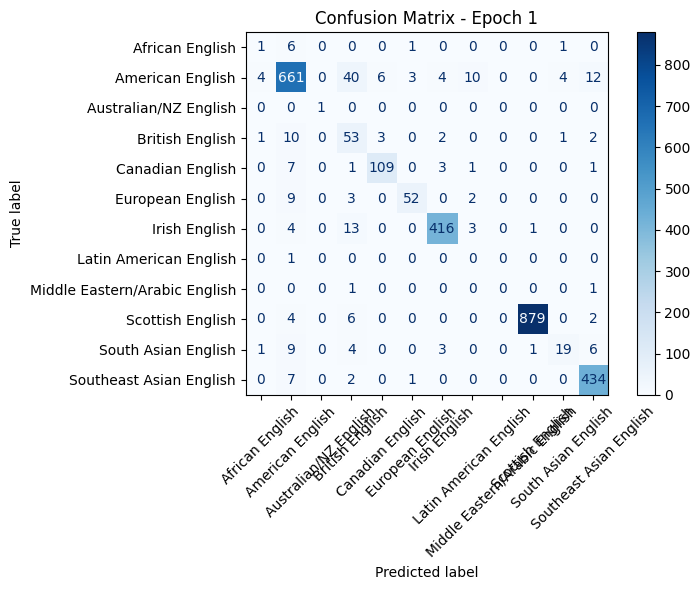

100%|██████████| 708/708 [50:33<00:00,  4.28s/it]



Epoch 2 - Train Loss: 0.0749 - Train Accuracy: 0.9738
Epoch 2 - Validation Loss: 0.2637 - Val Accuracy: 0.9333 - Weighted F1: 0.9330
                               precision    recall  f1-score   support

              African English       0.00      0.00      0.00         9
             American English       0.90      0.92      0.91       744
        Australian/NZ English       1.00      1.00      1.00         1
              British English       0.48      0.69      0.56        72
             Canadian English       0.97      0.89      0.93       122
             European English       0.89      0.82      0.85        66
                Irish English       0.97      0.95      0.96       437
       Latin American English       0.00      0.00      0.00         1
Middle Eastern/Arabic English       0.33      0.50      0.40         2
             Scottish English       1.00      0.99      0.99       891
          South Asian English       0.67      0.37      0.48        43
      Southea

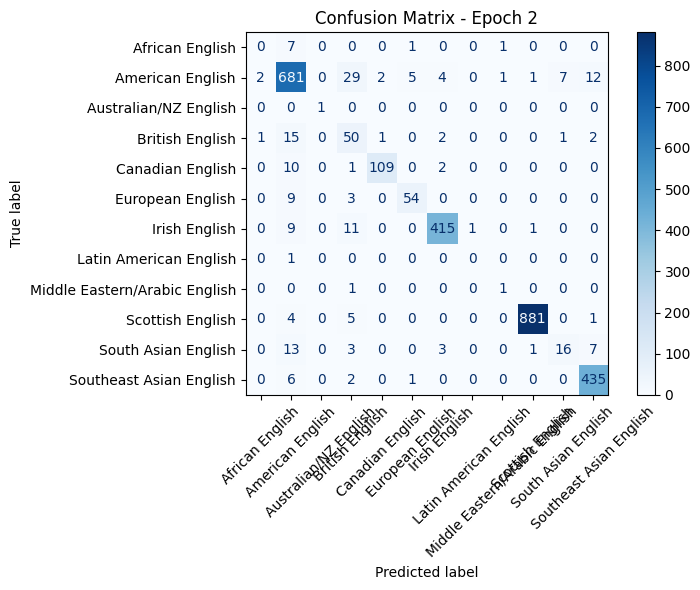

100%|██████████| 708/708 [49:38<00:00,  4.21s/it]



Epoch 3 - Train Loss: 0.0825 - Train Accuracy: 0.9717
Epoch 3 - Validation Loss: 0.2904 - Val Accuracy: 0.9244 - Weighted F1: 0.9283
                               precision    recall  f1-score   support

              African English       0.00      0.00      0.00         9
             American English       0.93      0.87      0.90       744
        Australian/NZ English       0.50      1.00      0.67         1
              British English       0.44      0.72      0.55        72
             Canadian English       0.96      0.89      0.93       122
             European English       0.90      0.80      0.85        66
                Irish English       0.97      0.96      0.96       437
       Latin American English       0.00      0.00      0.00         1
Middle Eastern/Arabic English       1.00      0.50      0.67         2
             Scottish English       1.00      0.99      0.99       891
          South Asian English       0.41      0.56      0.48        43
      Southea

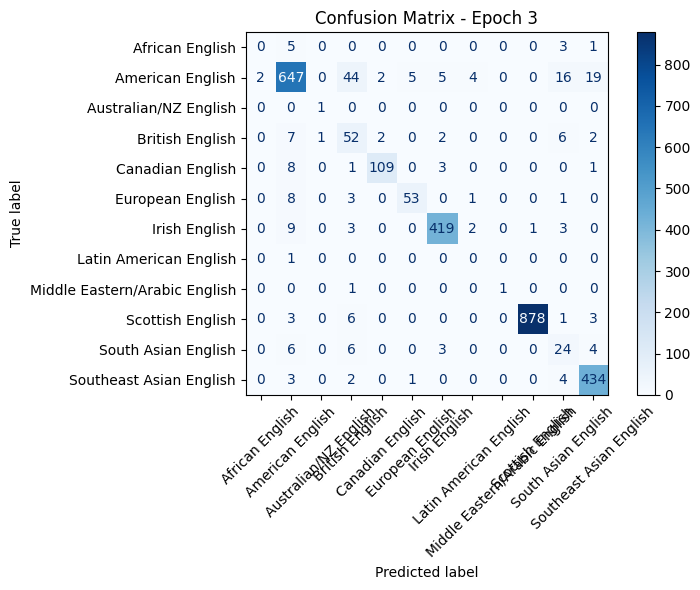

100%|██████████| 708/708 [51:23<00:00,  4.36s/it]



Epoch 4 - Train Loss: 0.1036 - Train Accuracy: 0.9702
Epoch 4 - Validation Loss: 0.3233 - Val Accuracy: 0.9145 - Weighted F1: 0.9223
                               precision    recall  f1-score   support

              African English       0.00      0.00      0.00         9
             American English       0.96      0.81      0.88       744
        Australian/NZ English       1.00      1.00      1.00         1
              British English       0.34      0.83      0.48        72
             Canadian English       0.96      0.92      0.94       122
             European English       0.89      0.85      0.87        66
                Irish English       0.95      0.97      0.96       437
       Latin American English       0.00      0.00      0.00         1
Middle Eastern/Arabic English       0.00      0.00      0.00         2
             Scottish English       1.00      0.99      0.99       891
          South Asian English       0.55      0.42      0.47        43
      Southea

c:\Simoh\Github\Transcription_Accent_Model_Comparer\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Simoh\Github\Transcription_Accent_Model_Comparer\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Simoh\Github\Transcription_Accent_Model_Comparer\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

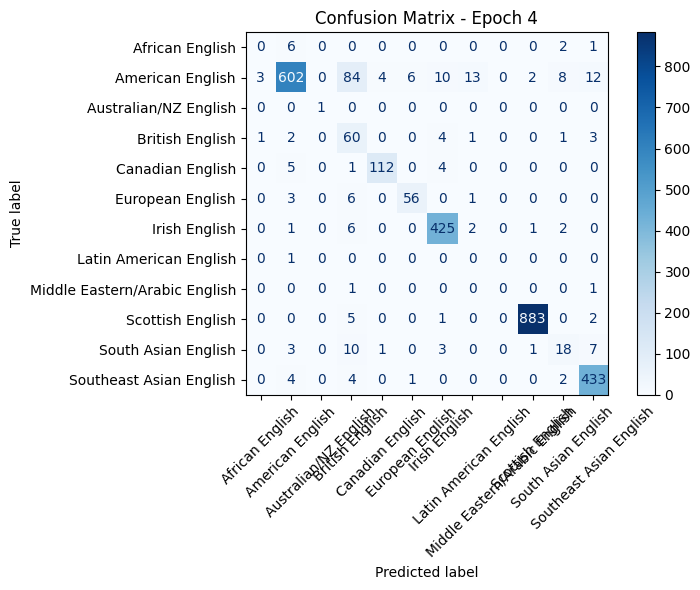

100%|██████████| 708/708 [51:57<00:00,  4.40s/it]



Epoch 5 - Train Loss: 0.0878 - Train Accuracy: 0.9687
Epoch 5 - Validation Loss: 0.2720 - Val Accuracy: 0.9368 - Weighted F1: 0.9359
                               precision    recall  f1-score   support

              African English       0.33      0.11      0.17         9
             American English       0.91      0.92      0.91       744
        Australian/NZ English       0.33      1.00      0.50         1
              British English       0.54      0.65      0.59        72
             Canadian English       0.95      0.93      0.94       122
             European English       0.93      0.76      0.83        66
                Irish English       0.98      0.96      0.97       437
       Latin American English       0.00      0.00      0.00         1
Middle Eastern/Arabic English       0.50      0.50      0.50         2
             Scottish English       1.00      0.99      0.99       891
          South Asian English       0.60      0.42      0.49        43
      Southea

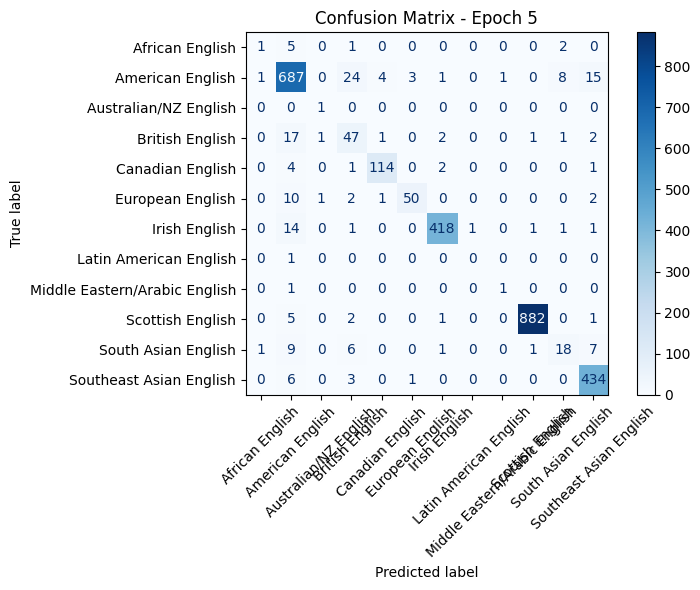

100%|██████████| 708/708 [52:33<00:00,  4.45s/it]



Epoch 6 - Train Loss: 0.0914 - Train Accuracy: 0.9679
Epoch 6 - Validation Loss: 0.3110 - Val Accuracy: 0.9322 - Weighted F1: 0.9299
                               precision    recall  f1-score   support

              African English       0.00      0.00      0.00         9
             American English       0.92      0.89      0.90       744
        Australian/NZ English       1.00      1.00      1.00         1
              British English       0.55      0.68      0.61        72
             Canadian English       0.90      0.89      0.90       122
             European English       0.89      0.82      0.85        66
                Irish English       0.94      0.98      0.96       437
       Latin American English       0.00      0.00      0.00         1
Middle Eastern/Arabic English       1.00      0.50      0.67         2
             Scottish English       0.99      0.99      0.99       891
          South Asian English       0.62      0.35      0.45        43
      Southea

c:\Simoh\Github\Transcription_Accent_Model_Comparer\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Simoh\Github\Transcription_Accent_Model_Comparer\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Simoh\Github\Transcription_Accent_Model_Comparer\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

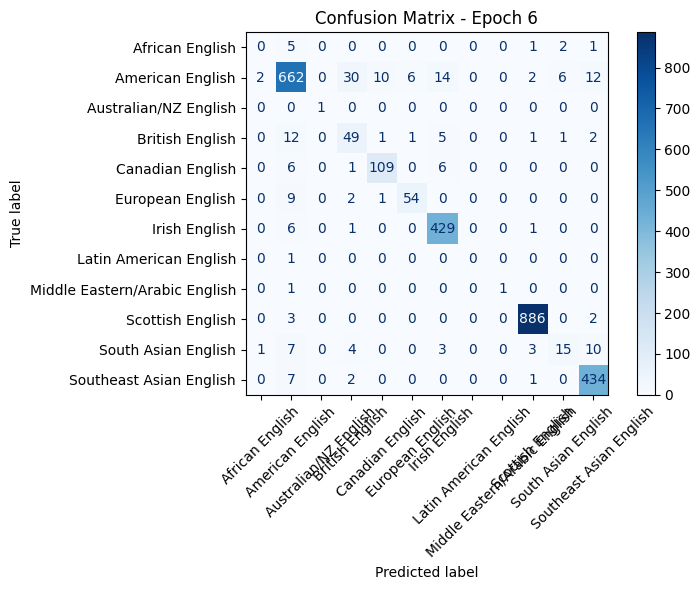

100%|██████████| 708/708 [51:00<00:00,  4.32s/it]



Epoch 7 - Train Loss: 0.1377 - Train Accuracy: 0.9623
Epoch 7 - Validation Loss: 0.3382 - Val Accuracy: 0.9191 - Weighted F1: 0.9231
                               precision    recall  f1-score   support

              African English       0.00      0.00      0.00         9
             American English       0.93      0.87      0.90       744
        Australian/NZ English       0.00      0.00      0.00         1
              British English       0.46      0.64      0.54        72
             Canadian English       0.96      0.89      0.92       122
             European English       0.90      0.80      0.85        66
                Irish English       0.95      0.94      0.95       437
       Latin American English       0.00      0.00      0.00         1
Middle Eastern/Arabic English       0.00      0.00      0.00         2
             Scottish English       1.00      0.99      0.99       891
          South Asian English       0.28      0.51      0.36        43
      Southea

c:\Simoh\Github\Transcription_Accent_Model_Comparer\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Simoh\Github\Transcription_Accent_Model_Comparer\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Simoh\Github\Transcription_Accent_Model_Comparer\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

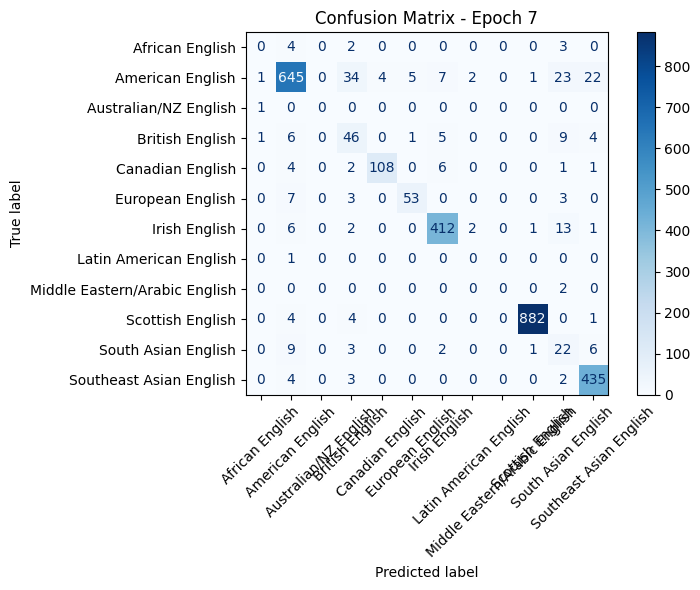

100%|██████████| 708/708 [52:32<00:00,  4.45s/it]



Epoch 8 - Train Loss: 0.1703 - Train Accuracy: 0.9513
Epoch 8 - Validation Loss: 0.3291 - Val Accuracy: 0.9244 - Weighted F1: 0.9276
                               precision    recall  f1-score   support

              African English       0.25      0.11      0.15         9
             American English       0.93      0.86      0.90       744
        Australian/NZ English       1.00      1.00      1.00         1
              British English       0.42      0.78      0.55        72
             Canadian English       0.99      0.88      0.93       122
             European English       0.81      0.86      0.84        66
                Irish English       0.96      0.98      0.97       437
       Latin American English       0.00      0.00      0.00         1
Middle Eastern/Arabic English       0.00      0.00      0.00         2
             Scottish English       1.00      0.98      0.99       891
          South Asian English       0.39      0.37      0.38        43
      Southea

c:\Simoh\Github\Transcription_Accent_Model_Comparer\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Simoh\Github\Transcription_Accent_Model_Comparer\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Simoh\Github\Transcription_Accent_Model_Comparer\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

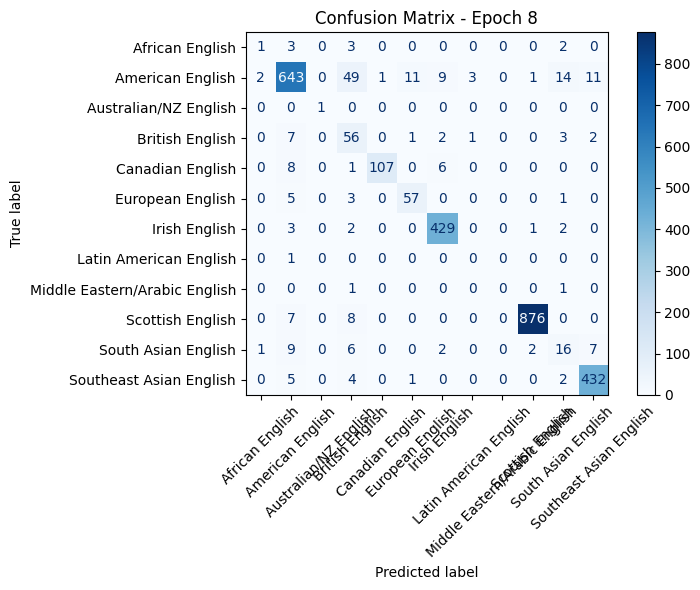

100%|██████████| 708/708 [52:25<00:00,  4.44s/it]



Epoch 9 - Train Loss: 0.2068 - Train Accuracy: 0.9445
Epoch 9 - Validation Loss: 0.2893 - Val Accuracy: 0.9227 - Weighted F1: 0.9274
                               precision    recall  f1-score   support

              African English       0.38      0.33      0.35         9
             American English       0.94      0.84      0.89       744
        Australian/NZ English       0.25      1.00      0.40         1
              British English       0.53      0.71      0.60        72
             Canadian English       0.92      0.91      0.91       122
             European English       0.86      0.89      0.87        66
                Irish English       0.97      0.96      0.97       437
       Latin American English       0.00      0.00      0.00         1
Middle Eastern/Arabic English       1.00      0.50      0.67         2
             Scottish English       0.99      0.99      0.99       891
          South Asian English       0.37      0.51      0.43        43
      Southea

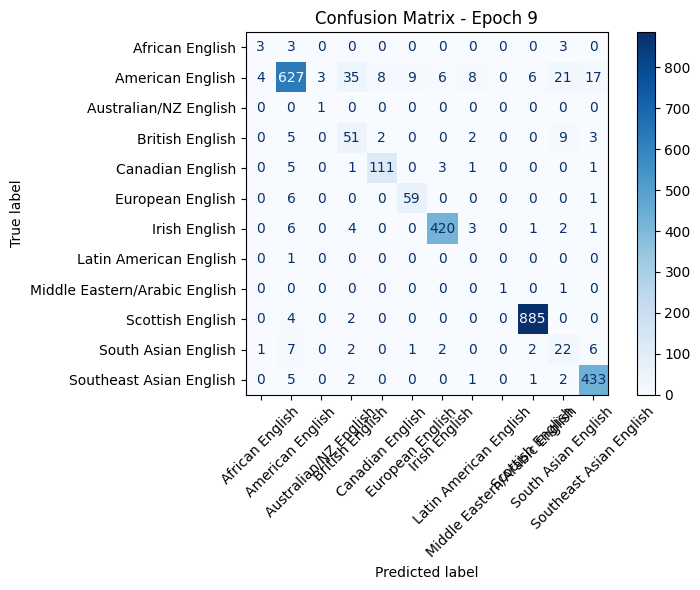

100%|██████████| 708/708 [52:26<00:00,  4.44s/it]



Epoch 10 - Train Loss: 0.0989 - Train Accuracy: 0.9661
Epoch 10 - Validation Loss: 0.3228 - Val Accuracy: 0.9255 - Weighted F1: 0.9261
                               precision    recall  f1-score   support

              African English       0.00      0.00      0.00         9
             American English       0.92      0.87      0.89       744
        Australian/NZ English       0.50      1.00      0.67         1
              British English       0.55      0.74      0.63        72
             Canadian English       0.98      0.86      0.92       122
             European English       0.90      0.85      0.88        66
                Irish English       0.96      0.97      0.96       437
       Latin American English       0.00      0.00      0.00         1
Middle Eastern/Arabic English       1.00      0.50      0.67         2
             Scottish English       1.00      0.99      0.99       891
          South Asian English       0.39      0.47      0.43        43
      South

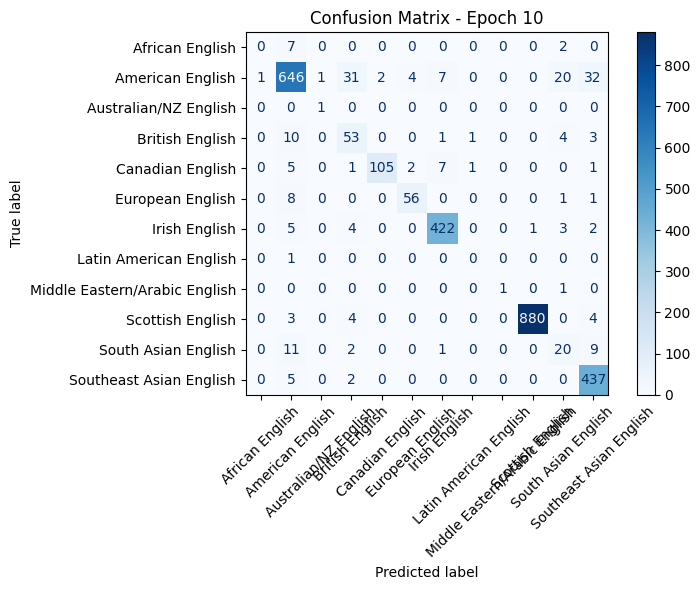

100%|██████████| 708/708 [52:47<00:00,  4.47s/it]



Epoch 11 - Train Loss: 0.0748 - Train Accuracy: 0.9720
Epoch 11 - Validation Loss: 0.3068 - Val Accuracy: 0.9304 - Weighted F1: 0.9314
                               precision    recall  f1-score   support

              African English       0.00      0.00      0.00         9
             American English       0.90      0.91      0.90       744
        Australian/NZ English       0.50      1.00      0.67         1
              British English       0.53      0.65      0.58        72
             Canadian English       0.96      0.89      0.93       122
             European English       0.89      0.83      0.86        66
                Irish English       0.98      0.96      0.97       437
       Latin American English       0.00      0.00      0.00         1
Middle Eastern/Arabic English       1.00      0.50      0.67         2
             Scottish English       1.00      0.98      0.99       891
          South Asian English       0.36      0.42      0.39        43
      South

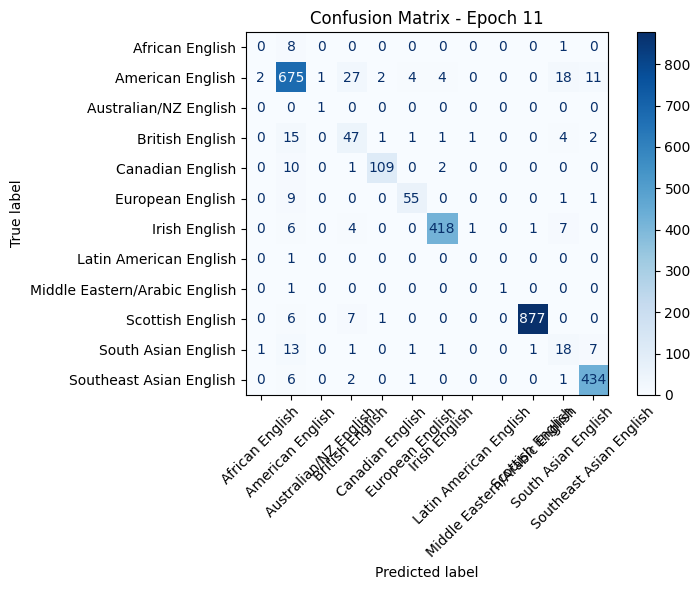

100%|██████████| 708/708 [52:36<00:00,  4.46s/it]



Epoch 12 - Train Loss: 0.0871 - Train Accuracy: 0.9711
Epoch 12 - Validation Loss: 0.3228 - Val Accuracy: 0.9188 - Weighted F1: 0.9254
                               precision    recall  f1-score   support

              African English       0.06      0.11      0.07         9
             American English       0.94      0.85      0.89       744
        Australian/NZ English       0.00      0.00      0.00         1
              British English       0.57      0.54      0.55        72
             Canadian English       0.87      0.91      0.89       122
             European English       0.84      0.85      0.84        66
                Irish English       0.98      0.96      0.97       437
       Latin American English       0.00      0.00      0.00         1
Middle Eastern/Arabic English       0.50      0.50      0.50         2
             Scottish English       1.00      0.99      0.99       891
          South Asian English       0.32      0.70      0.44        43
      South

c:\Simoh\Github\Transcription_Accent_Model_Comparer\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Simoh\Github\Transcription_Accent_Model_Comparer\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Simoh\Github\Transcription_Accent_Model_Comparer\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

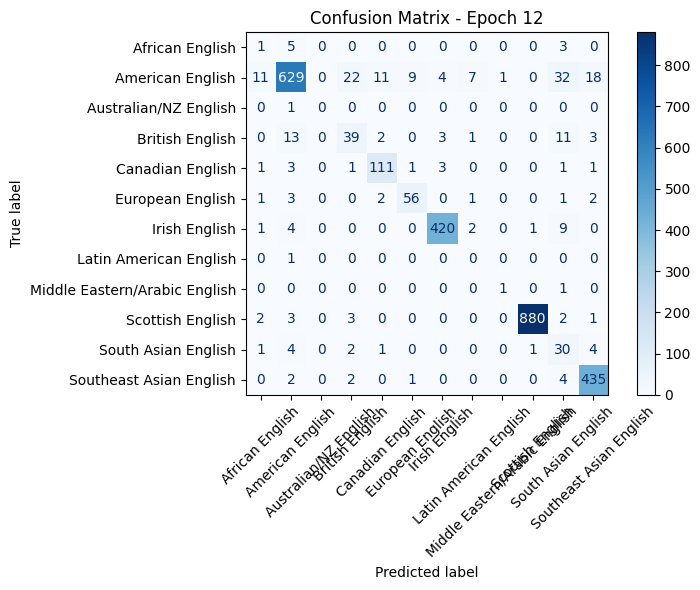

100%|██████████| 708/708 [52:38<00:00,  4.46s/it]



Epoch 13 - Train Loss: 0.0913 - Train Accuracy: 0.9684
Epoch 13 - Validation Loss: 0.2939 - Val Accuracy: 0.9280 - Weighted F1: 0.9333
                               precision    recall  f1-score   support

              African English       0.09      0.11      0.10         9
             American English       0.94      0.87      0.90       744
        Australian/NZ English       0.14      1.00      0.25         1
              British English       0.43      0.74      0.55        72
             Canadian English       0.93      0.91      0.92       122
             European English       0.89      0.85      0.87        66
                Irish English       0.98      0.97      0.97       437
       Latin American English       0.00      0.00      0.00         1
Middle Eastern/Arabic English       0.50      0.50      0.50         2
             Scottish English       1.00      0.98      0.99       891
          South Asian English       0.50      0.58      0.54        43
      South

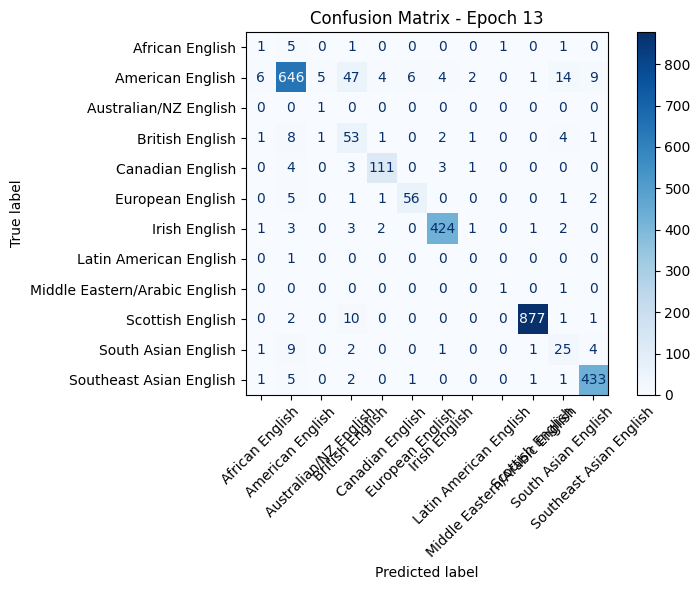

100%|██████████| 708/708 [52:41<00:00,  4.47s/it]



Epoch 14 - Train Loss: 0.1020 - Train Accuracy: 0.9665
Epoch 14 - Validation Loss: 0.3326 - Val Accuracy: 0.9174 - Weighted F1: 0.9250
                               precision    recall  f1-score   support

              African English       0.00      0.00      0.00         9
             American English       0.94      0.85      0.89       744
        Australian/NZ English       0.25      1.00      0.40         1
              British English       0.45      0.67      0.54        72
             Canadian English       0.95      0.86      0.90       122
             European English       0.92      0.86      0.89        66
                Irish English       0.95      0.95      0.95       437
       Latin American English       0.00      0.00      0.00         1
Middle Eastern/Arabic English       1.00      0.50      0.67         2
             Scottish English       1.00      0.99      0.99       891
          South Asian English       0.35      0.58      0.43        43
      South

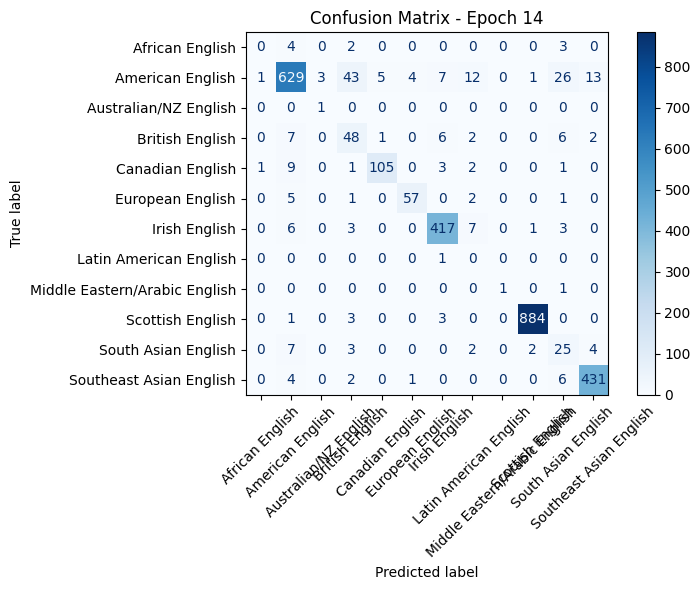

100%|██████████| 708/708 [51:58<00:00,  4.40s/it]



Epoch 15 - Train Loss: 0.1325 - Train Accuracy: 0.9660
Epoch 15 - Validation Loss: 0.4071 - Val Accuracy: 0.8987 - Weighted F1: 0.9107
                               precision    recall  f1-score   support

              African English       0.14      0.33      0.19         9
             American English       0.91      0.84      0.87       744
        Australian/NZ English       0.50      1.00      0.67         1
              British English       0.49      0.54      0.52        72
             Canadian English       0.91      0.89      0.90       122
             European English       0.81      0.86      0.84        66
                Irish English       0.98      0.93      0.96       437
       Latin American English       0.00      0.00      0.00         1
Middle Eastern/Arabic English       1.00      0.50      0.67         2
             Scottish English       1.00      0.97      0.98       891
          South Asian English       0.21      0.60      0.31        43
      South

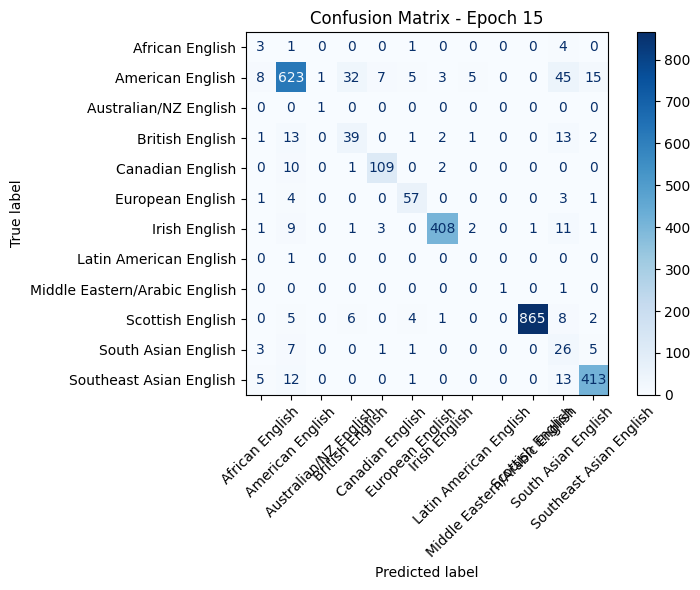

 19%|█▉        | 135/708 [10:02<42:36,  4.46s/it]


KeyboardInterrupt: 

In [ ]:
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score


best_accuracy = 0.0


for epoch in range(EPOCHS): 
    model.train()
    running_loss = 0.0
    
    train_preds = []
    train_labels = []
    
    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        loss = loss_fn(logits, batch["labels"])
        loss.backward()
        running_loss += loss.item()
        
        
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        train_preds.extend(predictions.detach().cpu().numpy())
        train_labels.extend(batch["labels"].detach().cpu().numpy())

        if (step + 1) % 4 == 0:  
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
    
    avg_train_loss = running_loss / len(train_dataloader)
    train_acc = accuracy_score(train_labels, train_preds)
    print(f"\nEpoch {epoch+1} - Train Loss: {avg_train_loss:.4f} - Train Accuracy: {train_acc:.4f}")

  
    model.eval()
    all_preds = []
    all_labels = []
    
    val_loss_total = 0.0

    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        val_loss_total += outputs.loss.item()
        
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())

    avg_val_loss = val_loss_total / len(eval_dataloader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")


    print(f"Epoch {epoch+1} - Validation Loss: {avg_val_loss:.4f} - Val Accuracy: {acc:.4f} - Weighted F1: {f1:.4f}")

    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(acc)
    history['val_f1_minority'].append(f1)
    
    
   
    target_names = accents
    report = classification_report(all_labels, all_preds, target_names=target_names, digits=2, output_dict=True)
    print(classification_report(all_labels, all_preds, target_names=target_names, digits=2))

    history["val_f1_macro"].append(report["macro avg"]["f1-score"])
    history["val_f1_weighted"].append(report["weighted avg"]["f1-score"])
    

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title(f"Confusion Matrix - Epoch {epoch+1}")
    plt.tight_layout()
    plt.show()

    if acc > best_accuracy:
        best_accuracy = acc
        torch.save(model.state_dict(), "output/best_model.pt")


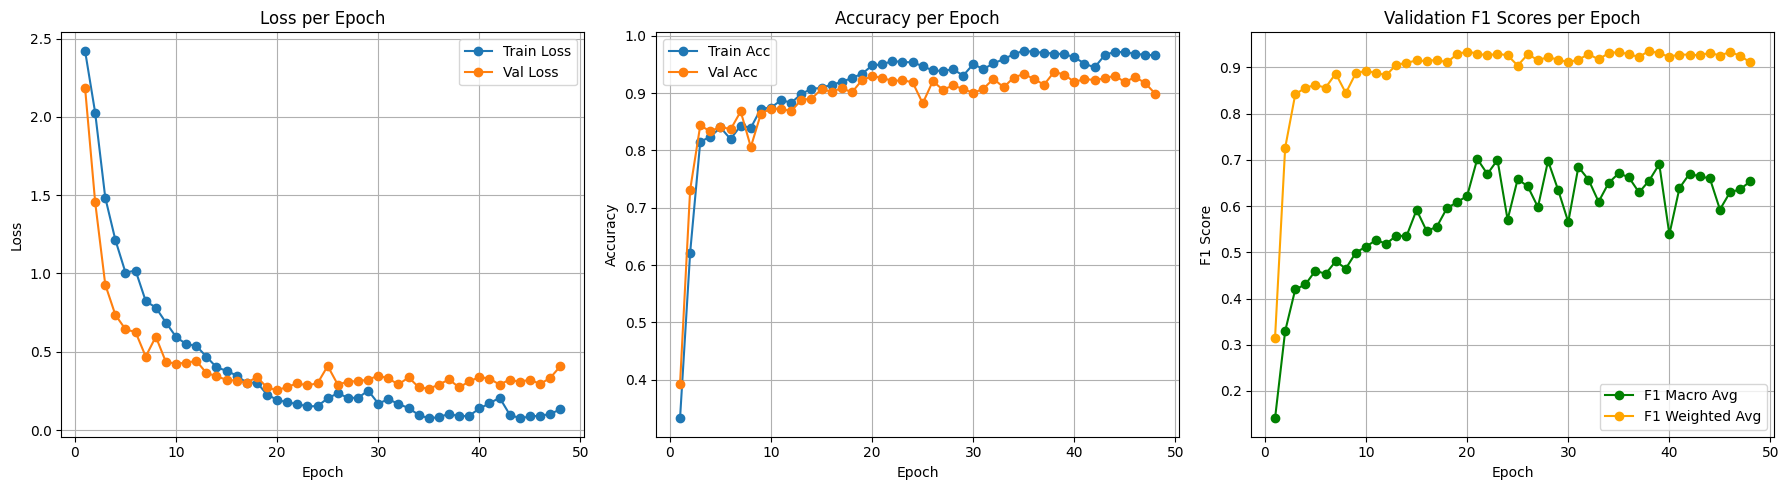

In [ ]:

epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, history['train_loss'], label='Train Loss', marker='o')
plt.plot(epochs, history['val_loss'], label='Val Loss', marker='o')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(epochs, history['train_acc'], label='Train Acc', marker='o')
plt.plot(epochs, history['val_acc'], label='Val Acc', marker='o')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(epochs, history['val_f1_macro'], label='F1 Macro Avg', marker='o', color='green')
plt.plot(epochs, history['val_f1_weighted'], label='F1 Weighted Avg', marker='o', color='orange')
plt.title("Validation F1 Scores per Epoch")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()


# Enregistrement et Réutilisation

In [ ]:
import sounddevice as sd
from scipy.io.wavfile import write


samplerate = 16000  
duration = 5        
filename = "audio/exemple.wav"

print("Enregistrement")
audio = sd.rec(int(duration * samplerate), samplerate=samplerate, channels=1, dtype='int16')
sd.wait()  
print(f"Fin")

write(filename, samplerate, audio)


🎙️ Enregistrement en cours... Parle maintenant !
✅ Audio sauvegardé sous ma_voix.wav


In [ ]:
import torch
import soundfile as sf
from transformers import AutoFeatureExtractor, Wav2Vec2ForSequenceClassification

device = "cuda" if torch.cuda.is_available() else "cpu"


feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base")


model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels=len(accents)
)


model.load_state_dict(torch.load("output/best_model.pt", map_location=device))
model.to(device)
model.eval()



Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted accent: American English


In [ ]:
audio_path = "audio/exemple.wav"
speech, sr = sf.read(audio_path)

inputs = feature_extractor(
    speech,
    sampling_rate=sr,
    return_tensors="pt",
    padding=True
)

inputs = {k: v.to(device) for k, v in inputs.items()}


with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=-1).item()

print(f"Predicted accent: {accents[predicted_class_id]}")